# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import math 
import warnings

warnings.simplefilter('ignore') 

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') #читаем файл и делим значения по сепаратору
#display(data.sample(10))
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [2]:
data.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3484,10,3750000.0,43.0,2017-11-03T00:00:00,1,2.50,9.0,NaN,3,NaN,...,NaN,NaN,Санкт-Петербург,48185.0,16165.0,0.0,NaN,0.0,NaN,117.0
8634,19,45900000.0,223.0,2017-09-20T00:00:00,5,3.10,10.0,175.0,10,NaN,...,18.0,NaN,Санкт-Петербург,26084.0,5807.0,3.0,411.0,1.0,478.0,365.0
12386,6,4950000.0,56.6,2017-08-21T00:00:00,3,NaN,9.0,36.7,4,NaN,...,8.7,1.0,Сестрорецк,61026.0,36245.0,0.0,NaN,2.0,136.0,485.0
9554,1,10828140.0,83.3,2016-09-24T00:00:00,2,NaN,5.0,NaN,2,NaN,...,NaN,NaN,Санкт-Петербург,37956.0,11491.0,1.0,161.0,1.0,149.0,793.0
10304,9,4490000.0,43.3,2017-12-19T00:00:00,1,3.00,16.0,16.0,11,NaN,...,9.2,2.0,Санкт-Петербург,15674.0,15582.0,0.0,NaN,1.0,640.0,282.0
15608,2,2250000.0,37.4,2018-02-10T00:00:00,1,2.80,4.0,15.3,2,NaN,...,11.3,1.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,76.0
23537,9,3600000.0,45.0,2017-06-14T00:00:00,2,2.50,5.0,28.7,3,False,...,5.5,1.0,Санкт-Петербург,12592.0,11154.0,0.0,NaN,1.0,658.0,45.0
14024,12,5550000.0,41.0,2018-02-14T00:00:00,1,2.65,17.0,17.0,11,NaN,...,10.0,NaN,Санкт-Петербург,36688.0,11841.0,0.0,NaN,2.0,981.0,60.0
10443,13,4610000.0,43.0,2019-03-22T00:00:00,2,2.50,5.0,29.0,4,NaN,...,5.5,NaN,Санкт-Петербург,42720.0,12596.0,1.0,432.0,0.0,NaN,NaN
2702,1,4450000.0,49.0,2018-04-21T00:00:00,4,2.50,5.0,38.0,4,NaN,...,5.5,NaN,Санкт-Петербург,11046.0,12150.0,0.0,NaN,1.0,776.0,NaN


### Вывод

<span style="text-decoration:underline">При помощи метода info() мы можем видеть несколько важных моментов: </span>

1) Количество наблюдений в более чем половине столбцов меньше общего числа наблюдений в сете. Количество наблюдений существенно снижается при приближении к "правой границе" сета. Вероятно, заполнение полей не обязательно в пользовательской форме, поэтому необходимо будет проанализировать каждый столбец и заполнить его, либо какими-то расчетными значениями, либо нулями;

2) Тип данных в столбце 'first_day_exposition' некорректный - вместо даты строковое значение;

3) Вероятно, тип данных в столбце 'floors_total' выбран не совсем корректно. Маловероятно, что количество этажей будет не целым числом. 

4) Столбец 'is_apartment' даже по контексту должнен быть заполнен булевыми значениями, а по факту - строковые;

В общем, мы видим, что данные имеют ряд проблемных мест. Потребуется провести масштабную работу для заполнения пропусков таким образом, чтобы новые значения в наименьшей степени повлияли на итоговый результат. 

Предположительно, для формирования и проверки гипотез по такому датасету потребуется использовать только определенные фрагменты датасета (в зависимости от анализируемой метрики).

### Шаг 2. Предобработка данных

In [3]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
#преобразуем значения столбца 'first_day_exposition' в дату из строки


In [4]:
data['ceiling_height'] = data['ceiling_height'].fillna(0)
#для корректной дальнейшей обработки заполняем пропуски нулями

In [5]:
data['ceiling_height'].describe()
#При помощи метода describe() мы видим минимум и максимум по высоте потолка. 
#Оба значения явно выделяются своей нереалистичностью (1 метр и 100 метров).
#Нам необходимо заполнить пропуски в столбце, но перед этим надо обработать имеющиеся данные. 

#При помощи небольшой функции, распределяем записи в группы по высоте потолков
def ceiling_height_gp(value):
    if value == 0:
        return 'Высота не указана'
    elif value < 2:
        return 'До 2 метров'
    elif value >= 2 and value <= 3:
        return 'От 2 до 3 метров'
    elif value > 3:
        return 'Более 3 метров'
    
data['ceiling_height_gp'] = data['ceiling_height'].apply(ceiling_height_gp) #добавляем столбец с группами
display(data.pivot_table(index='ceiling_height_gp', values='ceiling_height', aggfunc=['count', 'mean', 'median', 'min', 'max']))
#при помощи сводной таблицы оцениваем результат

data.drop(data.loc[data['ceiling_height_gp'] == 'До 2 метров'].index, inplace=True) 
#убираем из датасета группу "До 2 метров"
data = data.reset_index(drop=True) #сбрасываем индексы
display(data.info())

,count,mean,median,min,max
,ceiling_height,ceiling_height,ceiling_height,ceiling_height,ceiling_height
ceiling_height_gp,,,,,
Более 3 метров,1529,3.770320,3.26,3.01,100.00
Высота не указана,9195,0.000000,0.00,0.00,0.00
До 2 метров,3,1.316667,1.20,1.00,1.75
От 2 до 3 метров,12972,2.654105,2.60,2.00,3.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23696 entries, 0 to 23695
Data columns (total 23 columns):
total_images            23696 non-null int64
last_price              23696 non-null float64
total_area              23696 non-null float64
first_day_exposition    23696 non-null datetime64[ns]
rooms                   23696 non-null int64
ceiling_height          23696 non-null float64
floors_total            23610 non-null float64
living_area             21793 non-null float64
floor                   23696 non-null int64
is_apartment            2775 non-null object
studio                  23696 non-null bool
open_plan               23696 non-null bool
kitchen_area            21418 non-null float64
balcony                 12180 non-null float64
locality_name           23647 non-null object
airports_nearest        18155 non-null float64
cityCenters_nearest     18178 non-null float64
parks_around3000        18179 non-null float64
parks_nearest           8078 non-null float64
ponds_a

None

In [6]:
data['ceiling_height'].describe() #снова смотрим на значения столбца 'ceiling_height'
#минимальное значение в 2 метра звучит реалистично
#также видим, что 75% всех заполненных значений не превывышают 2,8 метра
data.loc[data['ceiling_height'] >= 2.8, 'ceiling_height'].describe() #отбираем группу свыше 2,8 и снова ее оцениваем
data.loc[data['ceiling_height'] >= 4, 'ceiling_height'].describe()
#несколькими итерациями отбора группы по 3 квартилю, мы приходим к тому, что группа свыше 4 метров включает значения
#не похожие на реальные (3 квартиль на уровне 7.5 метров)
#количество наблюдений в группе позволяет спокойно отсеять эти значения из датасета
print('Количество удаленных значений: ', len(data.loc[data['ceiling_height'] > 4]))
data.drop(data.loc[data['ceiling_height'] > 4].index, inplace=True) #убираем из датафрейма значения более 4 метров
data = data.reset_index(drop=True)

del data['ceiling_height_gp'] #удаляем временный столбец с группами по высоте потолка

Количество удаленных значений:  75


In [7]:
display(data['is_apartment'].value_counts())
#В 44 объявленях параметр 'is_apartment' указан как True.
data['is_apartment'] = data['is_apartment'].fillna(False)
#data.info()
#Столбец заполнен. Тип данных теперь корректный - булево значение. 

False    2710
True       44
Name: is_apartment, dtype: int64

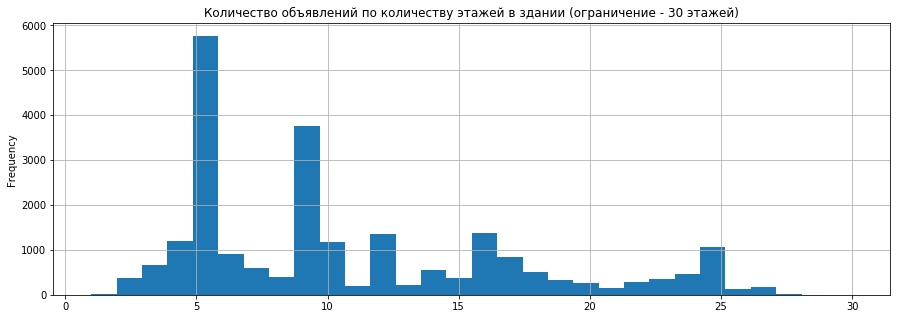

In [8]:
#data['floors_total'].sort_values().value_counts()
#display(data.loc[data['floors_total'].isnull() == False])
data['floors_total'].loc[data['floors_total'].isnull() == False]\
.plot(kind='hist', title='Количество объявлений по количеству этажей в здании (ограничение - 30 этажей)', \
range=(1, 30), figsize=(15, 5), bins=30, grid=True)

In [9]:
data['floors_total'] = data['floors_total'].fillna(data['floor']) #заполняем данные об общем количестве этажей
data['floors_total'].value_counts()

5.0     5767
9.0     3763
16.0    1373
12.0    1367
4.0     1202
10.0    1176
25.0    1074
6.0      914
17.0     833
3.0      662
7.0      590
14.0     553
18.0     508
24.0     470
8.0      397
2.0      382
15.0     368
23.0     353
19.0     342
22.0     287
20.0     273
13.0     232
11.0     206
27.0     164
21.0     162
26.0     123
1.0       28
35.0      24
28.0      21
36.0       2
29.0       1
60.0       1
33.0       1
52.0       1
34.0       1
Name: floors_total, dtype: int64

Мы видим, что некоторые типы зданий по этажности имеют не более 1-2 записей. Если предполагаем, что на базе исходного датасета необходимо создать расченую модель, нам лучше исключить эти выбросы из таблицы. Самый простой способ - убрать из таблицы все записи, общее количество этажей в которых превышает 35. На текущий момент, мы убрали из датасета 82 записи, что составляется примерно 0,0034% от исходного объема. 

In [10]:
data.drop(data.loc[data['floors_total'] > 35].index, inplace=True)
data = data.reset_index(drop=True)

Теперь мы располагаем нормализованными данными по этажности зданий и можем вернуться к заполнению столбца с высотой потолка конкретными значениями (ранее мы заполнили пропуски нулями). Сделаем это на основании предположения о том, что высота потолка напрямую связана с количеством этажей в здании.

In [11]:
ceiling_height_groups = data.loc[data['ceiling_height'] > 0].groupby('floors_total')['ceiling_height'].median().to_dict()
#отбираем значения с ненулевой высотой потолка
#делаем из них группировку, куда выводим медианное значения для каждого типа здания по этажности
#преобразуем группировку в словарь для присвоения стандартизированной высоты потолка в цикле

#функцией заменяем нулевые значения столбца ceiling_height высотами потолка
def ceiling_height_normalizer(row):
    if row['ceiling_height'] == 0: 
        if row['floors_total'] in ceiling_height_groups.keys():
            row['ceiling_height'] = ceiling_height_groups[row['floors_total']]
    return row
        
data = data.apply(ceiling_height_normalizer, axis=1) #применяем функцию

In [12]:
display(len(data.loc[data['ceiling_height'] == 0])) #повторно проверяем, есть ли строки с нулевой высотой потолка
#осталось 1 значение. В словаре не было пары для высоты здания в 33 этаже, поэтому мы вручную присвоем строке
#значение высоты потолка из ближайшего типа здания - выберем значение в 2.65 метра
data.loc[data['ceiling_height'] == 0, 'ceiling_height'] = 2.65

1

In [13]:
data['floors_total'] = data['floors_total'].astype(int) #общее количество этажей в здании не может быть выражено
#вещественным числом, поэтому преобразуем его в целое значение

В таблице присутствует столбец 'living_area', в котором меньше записей, чем в остальных столбцах. Нам известна общая площадь жилого помешения. Также известно, что значение жилой площади будет отличаться от общей площади жилого помещения, так как санитарные узлы и прочие подобные помещения присутствуют в любой квартире и их площадь не учитывается в качестве жилой, поэтому необходимо понять, как мы произведем заполнение пропусков на базе имеющейся информации. 

In [14]:
#display(data.corr()) #строим матрицу корреляции

#для простоты восприятия посчитаем и выведем коэффициент корреляции между для самых заметных значений
display(data['living_area'].corr(data['total_area'])) 
display(data['rooms'].corr(data['living_area']))

0.9377219524355874

0.8511408013766087

Корреляция между общей площадью квартиры и жилой площадью довольно очевидна, поэтому попробуем использовать для этого другое значение. Мы видим, что корреляция между количеством комнат и общей площадью составляет 85.1%.

Но для начала проанализируем, насколько корректно заполнен значениями столбцы с количеством комнат в квартире и общей площадью квартиры.

In [15]:
data['rooms'].describe()

count    23617.000000
mean         2.068764
std          1.076006
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [16]:
data['total_area'].describe()

count    23617.000000
mean        60.182956
std         35.044734
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Мы видим, что 75% всех значений в обеих группах близки к "реальным" - до 70 квадратных метров и до 3 комнат. Максимальное значение в 900 квадратных метров и 19 комнат требуют проверки - либо это аномалия, либо сегмент жилья класса "люкс". 

Но сначала обратим внимание на минимальное количество комнат равное нулю. Посмотрим, сколько таких значений в таблице и есть ли связь между площадью квартиры и нулевым количеством комнат в ней. Мы видим, что площадь помещения варьируется в диапазоне от 15,5 до 371 квадратных метров. 

In [17]:
display(len(data.loc[data['rooms'] == 0])) #количество записей с нулевым количеством комнат в квартире
data.loc[data['rooms'] == 0, 'total_area'].describe() 

195

count    195.000000
mean      29.087744
std       25.812455
min       15.500000
25%       24.025000
50%       26.050000
75%       28.350000
max      371.000000
Name: total_area, dtype: float64

In [18]:
data['room_sq'] = data['total_area'] / data['rooms'] #временно формируем столбец, в который запишем среднюю
#площадь комнаты в квартире 
avg_room_sq = data.loc[data['rooms'] != 0, 'room_sq'].mean().round() #среднее по столбцу со средней площади комнаты
median_room_sq = data.loc[data['rooms'] != 0, 'room_sq'].median().round() #медиана по столбцу со средней площадью комнаты
del data['room_sq']
print('Средняя площадь 1 комнаты составляет:', avg_room_sq, 'кв.м.')
print('Медианная площадь 1 комнаты составляет:', median_room_sq, 'кв.м.')

Средняя площадь 1 комнаты составляет: 31.0 кв.м.
Медианная площадь 1 комнаты составляет: 30.0 кв.м.


Среднее и медианное значения близки друг к другу, поэтому принципиальной разницы, какое из них будет использовано для заполнения нулевых значений по количеству комнат нет. Используем 30 квадратных метров для простоты восприятия.

In [19]:
def rooms_filler(row):
    if row['rooms'] == 0: #отбираем строки с нулевым значением
        row['rooms'] = math.ceil(row['total_area'] / median_room_sq) #считаем количество комнат и округляем 
#в большую сторону
#чтобы повторно не появились нули для значений менее 30 квадратных метров
    return row

data = data.apply(rooms_filler, axis=1)

In [20]:
display(len(data.loc[data['rooms'] == 0])) #повторно проверяем данные на нулевое количество комнат
display(data['rooms'].corr(data['living_area'])) #повторно проверяем корреляцию

0

0.8552992789520346

In [21]:
data['living_area'].describe()

count    21720.000000
mean        34.355145
std         21.653523
min          2.000000
25%         18.600000
50%         30.000000
75%         42.270000
max        409.700000
Name: living_area, dtype: float64

In [22]:
data.loc[data['living_area'] < 18, 'living_area'].describe()

count    4115.000000
mean       15.931638
std         1.661715
min         2.000000
25%        15.075000
50%        16.100000
75%        17.000000
max        17.970000
Name: living_area, dtype: float64

In [23]:
data['total_area'].describe()

count    23617.000000
mean        60.182956
std         35.044734
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

In [24]:
living_area_filled_old = data.loc[data['living_area'] != 0] #в отдельный массив отбираем значения с заполненной жил.площадью
living_area_filled_old['living_area_part'] = living_area_filled_old['living_area'] / living_area_filled_old['total_area']
#добавляем вычисляемый столбцев с долей жилой площади относительно общей площади

room_liv_area_part_groups_old = living_area_filled_old.groupby('rooms')['living_area_part'].mean().to_dict()
room_liv_area_part_groups_old[13] = room_liv_area_part_groups_old[11]

In [25]:
living_area_filled = data.loc[(data['living_area'] != 0) & (data['living_area'] >= data['living_area'].mean())] #в отдельный массив отбираем значения с заполненной жил.площадью
living_area_filled['living_area_part'] = living_area_filled['living_area'] / living_area_filled['total_area']
#добавляем вычисляемый столбцев с долей жилой площади относительно общей площади

room_liv_area_part_groups = living_area_filled.groupby('rooms')['living_area_part'].mean().to_dict()
room_liv_area_part_groups[13] = room_liv_area_part_groups[11]

In [26]:
room_liv_area_part_groups_comparison1 = pd.DataFrame.from_dict(room_liv_area_part_groups, orient='index', columns=['rows'])
room_liv_area_part_groups_comparison1.reset_index(inplace=True)
room_liv_area_part_groups_comparison1.columns=['rooms', 'living_area_part']
room_liv_area_part_groups_comparison2 = pd.DataFrame.from_dict(room_liv_area_part_groups_old, orient='index', columns=['rows'])
room_liv_area_part_groups_comparison = room_liv_area_part_groups_comparison1.join(room_liv_area_part_groups_comparison2, on='rooms')
room_liv_area_part_groups_comparison.columns=['rooms', 'new_liv_area_part', 'old_liv_area_part']

In [27]:
living_area_filled = data.loc[(data['living_area'] != 0) & (data['living_area'] >= data['living_area'].mean())] #в отдельный массив отбираем значения с заполненной жил.площадью
living_area_filled['living_area_part'] = living_area_filled['living_area'] / living_area_filled['total_area']
#добавляем вычисляемый столбцев с долей жилой площади относительно общей площади

room_liv_area_part_groups = living_area_filled.groupby('rooms')['living_area_part'].mean().to_dict()
room_liv_area_part_groups[13] = room_liv_area_part_groups[11]
#формируем словарь с парами количество комнат-доля жилой площади для применения в функции для заполнения 
#нулевых значений

data['living_area'] = data['living_area'].fillna(0) #заполняем незаполненные строки нулями

def living_area_filler(row):
    if row['living_area'] == 0:
        if row['rooms'] in room_liv_area_part_groups.keys():
            row['living_area'] = row['total_area'] * room_liv_area_part_groups[row['rooms']]
    return row
    
data = data.apply(living_area_filler, axis=1) #применяем функцию

При первоначальном изучении группировки мы видим странный коэффициент жилой площади для квартир с 12 комнатами. Таких записей в таблице 2, поэтому из соображений экономии времени мы удаляем эти две записи из датасета.

Также значение количества комнат для единственной 13-комнатной квартиры было получено расчетным путем, поэтому для простоты расчета паре для 13-комнатной квартиры было присвоено значение 11-комнатной квартиры.

In [28]:
data['living_area'].describe()
#display(room_liv_area_part_groups)
#len(data.loc[data['rooms'] == 12])  #считаем количество 12комнатных квартир в датасете
data.drop(data.loc[data['rooms'] == 12].index, inplace=True)
data = data.reset_index(drop=True)

Перейдем к анализу и заполнению данных о площади кухни. Можно предположить, что отсутствие данных о кухне равносильно отсутствию кухни в квартире и это возможно (в отличие от нулевого или идентичного общей площади значения жилой площади квартиры). Однако отсутствие отдельной кухни характерно для квартир типа "студия", что означает возможное нулевое значение кухни для группы однокомнатных квартир. 

По этой причине мы можем присвоить нулевую площадь кухни однокомнатным квартирам, а для остального пула необходимо произвести расчет по аналогии с жилой площадью. 

In [29]:
data['kitchen_area'] = data['kitchen_area'].fillna(0) #заполняем все пустые строки нулевыми значениями
print(len(data.loc[(data['kitchen_area'] == 0)&(data['rooms'] == 1)])) #считаем количество значений с нулевой
#площадью кухни у однокомнатных квартир

994


Однако принудительное присвоение нулевого значения 1000 строк только на основании количества комнат может значительно исказить наши данные, поэтому для заполнения нулевых значений площади кухни в однокомнатных квартирах мы вычислим медианное значение общей площади квартиры и оставим нулевое значение только у тех записей, площадь которых находится ниже второго квартиля. 

Нижнюю половину также можно классифицировать по количеству этажей - если этажность не превышает 12 этажей, то вероятней всего - эти дома старой постройки и в них также есть отдельная кухня.

Также мы в явном виде используем значение в столбце open_plan.

In [30]:
#строим сводную таблицу для поиска решения по заполнению пропусков у однокомнатных квартир
data.loc[data['kitchen_area'] != 0].pivot_table(index='rooms', values=['kitchen_area', 'total_area'], \
aggfunc=['mean', 'median', 'min']) 

mean                   median                     min           
      kitchen_area  total_area kitchen_area total_area kitchen_area total_area
rooms                                                                         
1         9.551731   37.814807        9.055      36.80          1.3       14.0
2         9.972598   55.822697        8.715      53.00          2.0       20.0
3        11.293762   77.615247        9.500      72.80          4.0       40.1
4        13.669963  107.180102       11.100      99.05          4.8       48.0
5        17.861714  157.447107       15.000     145.20          5.0       40.0
6        21.102447  203.628191       19.300     182.85          5.9       87.0
7        21.938000  255.968000       19.750     210.70          5.0      125.0
8        24.866667  257.722222       25.000     235.00          5.0      150.0
9        25.071429  316.114286       14.300     309.70         11.7      249.9
10       22.866667  259.566667       19.800     272.60         18.8      216.1
11       12.600000  188.900000       12.600     188.90         11.9      183.7
14       21.250000  304.200000       21.250     304.20         16.6      245.4
15      100.000000  590.000000      100.000     590.00        100.0      590.0
16       13.000000  270.000000       13.000     270.00         13.0      270.0
19       27.600000  374.600000       27.600     374.60         27.6      374.6

In [31]:
data['kitchen_area_part'] = data['kitchen_area'] / data['total_area'] #добавляем вычисляемый столбец
kitchen_area_part_groups = data.loc[data['kitchen_area'] != 0].\
groupby('rooms')['kitchen_area_part'].mean().to_dict() #делаем список для функции
del data['kitchen_area_part'] #удаляем вычисляемый столбец

def kitchen_area_filler(row): #функцией заполняем площадь кухни
    if row['kitchen_area'] == 0:
        if row['rooms'] == 1 and row['floor'] > 12 and row['total_area'] < 36.8 or row['open_plan'] == True: 
            row['kitchen_area'] = row['kitchen_area']
        elif row['rooms'] in kitchen_area_part_groups.keys():
            row['kitchen_area'] = row['total_area'] * kitchen_area_part_groups[row['rooms']]
        else:
            row['kitchen_area'] = row['total_area'] * kitchen_area_part_groups[row['rooms'] + 1]
    return row

data = data.apply(kitchen_area_filler, axis=1) #применяем функцию

In [32]:
print(len(data.loc[(data['kitchen_area'] == 0)&(data['rooms'] == 1)]))
#в итоге, мы сократили площадь квартир с нулевой площадью с порядка 2000 тысяч строк до 182

182


В качестве следующего шага исправим пропуски в столбце balcony. Так как балкон - довольно существенный параметр, напрямую влияющий на стоимость квартиры и ее привлекательность как объекта недвижимости для некоторых категорий покупателей, пустую строку мы будем расценивать как ноль. Соответственно пропуски в количестве балконов заполним нулями, а также преобразуем значения столбца в целое число. 

In [33]:
data['balcony'] = data['balcony'].fillna(0).astype(int)
data['balcony'].value_counts()

0    15229
1     4178
2     3645
5      301
4      182
3       81
Name: balcony, dtype: int64

Первичное ознакомление со столбцом locality_name

In [34]:
display(len(data['locality_name'].value_counts()))
data['locality_name'] = data['locality_name'].fillna('Не указано')
data = data.reset_index(drop=True)

363

При помощи нескольких итераций визуальной оценки семплов дета сета по столбцу locality_name, удалось определить наиболее распространенные избыточно длинные или немного различные значения (количество уникальных значений по столбцу сократилось на 7). 

In [35]:
def locality_adjustment(row):
    if 'посёлок' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('посёлок', 'п.')
    elif 'поселок' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('поселок', 'п.')
    elif 'садоводческое некоммерческое товарищество' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('садоводческое некоммерческое товарищество', 'снт')
    elif 'садовое товарищество' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('садовое товарищество', 'снт')
    elif 'городской поселок' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('городской поселок', 'пгт')
    elif 'поселок городского типа' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('поселок городского типа', 'пгт')
    elif 'деревня' in row['locality_name']:
        row['locality_name'] = row['locality_name'].replace('деревня', 'д.')
    return row

data = data.apply(locality_adjustment, axis=1)

После произведенных манипуляций, мы видим, что данными заполнены почти все столбцы. Исключение - столбцы с расстояними до ближайших важных инфраструктурных объектов, но к анализу данных приступить можно уже сейчас. Однако перед этим имеет смысл произвести преобразование данных ряда столбцов из формата вещественных чисел в целые.

Во-первых, наличие данных о копейках в цене квартиры не имеет определяющего значения для исследования;

Во-вторых, столбцы с площадями также не требуют такой точности.

In [36]:
data['last_price'], data['total_area'], data['living_area'], data['kitchen_area'] = \
data['last_price'].astype(int), data['total_area'].astype(int), data['living_area'].astype(int),\
data['kitchen_area'].astype(int), 

In [37]:
data.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21823,2,5886750,83,2018-07-30,2,2.55,9,36,2,False,...,29,0,Не указано,NaN,NaN,NaN,NaN,NaN,NaN,169.0
13808,19,6550000,55,2019-04-22,2,2.50,9,32,3,False,...,11,0,Санкт-Петербург,29638.0,13663.0,0.0,NaN,1.0,842.0,NaN
14569,8,3770000,45,2019-03-20,2,2.55,9,28,2,False,...,6,0,Санкт-Петербург,43932.0,16436.0,1.0,1.0,0.0,NaN,42.0
2833,2,2200000,40,2018-11-21,1,2.80,3,16,2,False,...,15,0,п. Романовка,NaN,NaN,NaN,NaN,NaN,NaN,27.0
5401,0,3300000,38,2018-09-07,1,2.50,9,18,3,False,...,8,0,Санкт-Петербург,15683.0,14479.0,2.0,594.0,1.0,410.0,8.0
14036,8,51000000,402,2017-02-07,6,3.15,8,300,6,False,...,56,2,Санкт-Петербург,24484.0,5052.0,1.0,253.0,0.0,NaN,32.0
1202,0,6700000,67,2016-05-19,2,2.70,18,38,6,False,...,11,0,Санкт-Петербург,33623.0,14722.0,0.0,NaN,1.0,506.0,53.0
1920,15,6300000,60,2017-05-10,2,2.78,17,31,11,False,...,13,1,Санкт-Петербург,17101.0,17110.0,0.0,NaN,0.0,NaN,55.0
6724,12,11500000,89,2018-11-04,3,3.00,6,48,2,False,...,7,0,Санкт-Петербург,12729.0,7889.0,1.0,437.0,3.0,535.0,NaN
18408,8,6500000,66,2016-06-01,2,2.60,10,30,10,False,...,14,2,Санкт-Петербург,38802.0,12499.0,1.0,646.0,0.0,NaN,96.0


Также в срезе присутствуют столбцы, указывающие на количество определенных инфраструктурных объектов:

1. parks_around3000
2. ponds_around3000

Значения в этих столбцах также необходимо преобразовать в целые числа, но в данных есть пропуски. Однако следует понимать, что без анализа географического положения каждого объекта недвижимости мы не можем заполнить пропуски какими-то значениями отличными от нуля = мы считаем, что пропуск равносилен отсутствию указанных объектов на заданном расстоянии от объекта недвижимости.

Также мы можем предположить, что для указанных строк мы можем заполнить нулями столбцы с расстоянием до ближайших парков или прудов.

In [38]:
display(len(data.loc[data['parks_around3000'].isnull()])) #5503 строки с NaN в количестве парков поблизости
data['parks_around3000'] = data['parks_around3000'].fillna(0) #заполняем NaN нулями

#display(data.loc[(data['parks_around3000'] == 0) & (data['parks_nearest'] > 0)]) 
#проверяем, у скольких парков после заполнения пропусков есть информация в колонке с расстоянием до ближайшего парка
#и видим, что такие есть, но
#все парки действительно далее 3 км от объекта недвижимости

#display(data.loc[(data['parks_around3000'] == 0) & (data['parks_nearest'].isnull())])
#проверяем, у скольких парков с нулевым количеством в округе ближайших 3 км пропуск в расстоянии - таких более 15 тысяч

data['parks_nearest'] = data['parks_nearest'].fillna(0) #заполняем пропуски в ближайших парках

5503

Проводим аналогичную процедуру для водоемов:

In [39]:
display(len(data.loc[data['ponds_around3000'].isnull()])) #аналогичные 5503 NaN-строк для прудов поблизости
#Можно предположить, что это те же объекты, что и в случае с парками. 

data['ponds_around3000'] = data['ponds_around3000'].fillna(0) #заполняем NaN нулями

#display(data.loc[(data['ponds_around3000'] == 0) & (data['ponds_nearest'] > 0)]) 
#однако мы видим, что количество строк, где количество ближайших водоемов равно нулю, но есть данные о расстоянии
#до ближайшего водоема равно 0

#display(data.loc[(data['ponds_around3000'] == 0) & (data['ponds_nearest'].isnull())])
#похожая ситуация: 14.5 тысяч строк с пропуском в расстоянии до пруда. Заполним эти пропуски, чтобы работа с данными
#была проще

data['ponds_nearest'] = data['ponds_nearest'].fillna(0) #заполняем пропуски

5503

In [40]:
data['parks_around3000'], data['ponds_around3000'], data['parks_nearest'], data['ponds_nearest'] = \
data['parks_around3000'].astype(int), data['ponds_around3000'].astype(int), data['parks_nearest'].astype(int),\
data['ponds_nearest'].astype(int)
#преобразуем тип данных в обработанных столбцах к целом числу для простоты обработки
#избыточная точность в десятых метров нам не нужна, а количество объектов может измеряться только целыми числами

Также мы можем преобразовать столбец с количеством дней до снятия объявления. 

Если бы строки в датасете не были двухлетней давности, то в качестве количества дней можно было бы использовать вычисляемое значение - разность между текущей датой и датой размещения. Однако в указанных условиях сделать это невозможно, так как избыточно большие цифры исказят данные, поэтому нам проще заполнить пропуски в данных нулями для однородности и полноты данных.

In [41]:
len(data.loc[data['days_exposition'] == 0])
#мы видим, что количество строк с нулевой дельтой между размещением и снятие равно нулю
#поэтому нулевое значение, которым мы заполним пропуски, будет также выступать маркером этой особенности нашего датасета

data['days_exposition'] = data['days_exposition'].fillna(0).astype(int)

Руководствуясь похожей логикой, мы заполним пропуски в расстояниях до ближайшего аэропорта и центра города нулями. Предположительно, пропуски в этих значениях говорят о локации объекта недвижимости в области, где расстояние до аэропорта, например, не принципиально, так как оно во всех случаях не сможет выступать в качестве преимущества. 

Кроме того, расстояние расстояние до аэропорта или центра города предполагает, что перемещение в эту локацию будет происходить с использованием какого-то вида транспорта, поэтому для простоты и наглядности результатов потенциального анализа метрики мы пересчитаем расстояние в километры с точностью до 1 знака после запятой. 

In [42]:
data['airports_nearest'] = round(data['airports_nearest'].fillna(0) / 1000, 1)
#data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna('Нет данных')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23616 entries, 0 to 23615
Data columns (total 22 columns):
total_images            23616 non-null int64
last_price              23616 non-null int64
total_area              23616 non-null int64
first_day_exposition    23616 non-null datetime64[ns]
rooms                   23616 non-null int64
ceiling_height          23616 non-null float64
floors_total            23616 non-null int64
living_area             23616 non-null int64
floor                   23616 non-null int64
is_apartment            23616 non-null bool
studio                  23616 non-null bool
open_plan               23616 non-null bool
kitchen_area            23616 non-null int64
balcony                 23616 non-null int64
locality_name           23616 non-null object
airports_nearest        23616 non-null float64
cityCenters_nearest     18112 non-null float64
parks_around3000        23616 non-null int64
parks_nearest           23616 non-null int64
ponds_around3000       

### Вывод

Мы преобразовали итоговый датафрейм, заполнив пропуски. Для заполнения ряда столбцов были предложены алгоритмы, учитывающие дополнительные характеристики (в частности, заполнение пропусков в площадях). К сожалению, по ряду столбцов заполнение было произведено нулевыми значениями в силу отсутствия других адекватных методов - при анализе таких метрик (например, времени жизни объявления на сайте), придется использовать более узкую выборку.

### Шаг 3. Посчитайте и добавьте в таблицу

In [43]:
#считаем стоимость 1 квадратного метра жилой площади и одновременно меняем тип полученных данных на целое число
data['price_per_sqm'] = (data['last_price'] / data['total_area']).astype(int)

#из ранее преобразованной даты получаем день недели, в которые объявление впервые было опубликовано
data['weekday_published'] = pd.to_datetime(data['first_day_exposition']).dt.dayofweek

#функция определит группу объекта недвижимости по этажности
def floor_gr_identifier(row):
    if row['floor'] == 1:
        row['floor_quality'] = 'Первый этаж'
    elif row['floors_total'] - row['floor'] == 0:
        row['floor_quality'] = 'Последний этаж'
    else:
        row['floor_quality'] = 'Другой'
    return row

data = data.apply(floor_gr_identifier, axis=1) #используем написанную функцию

In [44]:
#считаем долю жилой площади и площади кухни относительно общей площади объектов недвижимости
data['living_area_part'] = round(data['living_area'] / data['total_area'], 2)
data['kitchen_area_part'] = round(data['kitchen_area'] / data['total_area'], 2)

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

<p style="font-size:20px">4.1 Анализ площади</p>  

In [45]:
data['total_area'].describe()

count    23616.000000
mean        59.918953
std         34.627969
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        631.000000
Name: total_area, dtype: float64

При помощи метода describe мы можем оценить, как распределяются площади квартир из нашего среза. В среднем, площадь квартиры из объявления почти 60 квадратных метров. Медианное значение, конечно, немного ниже - 52 метра, но все равно эта цифра положительно характеризует ситуацию с площадью квартиры на рынке недвижимости. Однако мы видим, что с двух "концов" среза есть как ультрабюджетное жилье (в случае 12 квадратных метров нельзя быть полностью уверенным, что это отдельная квартира), так и жилье сегмента люкс (максимальное значение среза - 631 квадратный метр).

В зависимости от поставленных задач, возможно, будет иметь смысл исключение определенных групп из выборки для снижения размаха в данных.

Для наглядности, посмотрим на данные в трех разрезах, сгруппировав их по количеству комнат.

In [46]:
data.pivot_table(index='rooms', values=['total_area', 'living_area', 'kitchen_area'], aggfunc=['median', 'mean', 'max'])

median                                mean              \
      kitchen_area living_area total_area kitchen_area living_area   
rooms                                                                
1              9.0        17.0       36.0     9.000488   18.261841   
2              8.0        30.0       53.0     9.665785   31.530841   
3              9.0        45.0       72.0    11.010356   47.370901   
4             11.0        64.0       99.0    13.401869   67.389125   
5             15.0        91.0      145.0    17.498433   98.507837   
6             19.0       123.0      183.5    20.578431  131.529412   
7             20.0       145.0      213.0    22.368421  166.105263   
8             24.0       161.0      235.5    24.500000  168.500000   
9             15.5       169.5      300.5    23.750000  184.125000   
10            19.0       161.0      272.0    22.333333  165.000000   
11            12.0       133.5      188.5    12.000000  133.500000   
13             0.0       263.0      371.0     0.000000  263.000000   
14            20.5       195.0      304.0    20.500000  195.000000   
15           100.0       409.0      590.0   100.000000  409.000000   
16            13.0       180.0      270.0    13.000000  180.000000   
19            27.0       264.0      374.0    27.000000  264.000000   

                           max                         
       total_area kitchen_area living_area total_area  
rooms                                                  
1       37.159302          123         324        494  
2       55.532226           93         113        196  
3       77.460822          107         227        363  
4      107.334749           77         323        500  
5      157.003135           66         272        488  
6      200.696078           56         334        500  
7      260.877193           70         414        631  
8      259.083333           45         260        373  
9      305.750000           50         250        400  
10     259.333333           30         189        290  
11     188.500000           13         138        194  
13     371.000000            0         263        371  
14     304.000000           25         222        363  
15     590.000000          100         409        590  
16     270.000000           13         180        270  
19     374.000000           27         264        374

К себе сразу же привлекает внимание сегмент "люкс". В сводной таблице видна "солидарность" и "ровность" медианных и средних значений для квартир с 7 и более комнатами. Вероятно, таких значений немного, но они существенно влияют на цифры, описывающие весь датасет. 

Кроме того, общая площадь ряда объектов недвижимости с более чем 9 комнатами парадоксально мала для такого количества комнат, а с квартир с 7 комнатами общая площадь вообще начинает убывать. Природа таких данных в данном случае требует более глубокого погружения для понимания, что избыточно в рамках исследования. 

Оценим количество таких записей в датасете:

In [47]:
display(len(data.loc[data['rooms'] > 7]))
display(len(data.loc[data['rooms'] > 7]) / len(data))

31

0.001312669376693767

Мы видим, что таких записей всего 31, что составляет порядка 0,13% от общего текущего объема датасета. Можем сделать допущение, что такие записи возможно исключить из набора.

In [48]:
data.drop(data.loc[data['rooms'] > 7].index, inplace=True) 
data = data.reset_index(drop=True) #сбрасываем индексы
data.pivot_table(index='rooms', values=['total_area', 'living_area', 'kitchen_area'], aggfunc=['median', 'mean', 'max'])

median                                mean              \
      kitchen_area living_area total_area kitchen_area living_area   
rooms                                                                
1                9          17       36.0     9.000488   18.261841   
2                8          30       53.0     9.665785   31.530841   
3                9          45       72.0    11.010356   47.370901   
4               11          64       99.0    13.401869   67.389125   
5               15          91      145.0    17.498433   98.507837   
6               19         123      183.5    20.578431  131.529412   
7               20         145      213.0    22.368421  166.105263   

                           max                         
       total_area kitchen_area living_area total_area  
rooms                                                  
1       37.159302          123         324        494  
2       55.532226           93         113        196  
3       77.460822          107         227        363  
4      107.334749           77         323        500  
5      157.003135           66         272        488  
6      200.696078           56         334        500  
7      260.877193           70         414        631

Убрали всего 31 строку и сократили сводную таблицу вдвое! 

Однако в сводной таблице есть другие значения, вызывающие вопросы. В частности, таковыми можно назвать аномально большие квартиры с 1-3 комнатами (особенно, квартира с 1 комнатой общей площадью почти 500 квадратных метров). 

Такие записи требуют отдельного рассмотрения и, при необходимости, удаления из датасета. 

In [49]:
#data.loc[(data['rooms'] == 1) & (data['total_area'] > 150)]
#мы видим, что в таблице всего значение для однокомнатной квартиры с площадью более 200 метров. Разрыв с предыдущим
#304 квадратны метра. Это похоже на аномалию и такое значение вполне можно убрать из выборки.
data.drop(data.loc[(data['rooms'] == 1) & (data['total_area'] > 200)].index, inplace=True) 
data = data.reset_index(drop=True) #сбрасываем индексы

#data.loc[(data['rooms'] == 2) & (data['total_area'] > 150)]
#выборка двухкомнатных квартир с площадью более 150 метров возвращает всего 6 значений, но
#разрыв в площадях не такой большой, поэтому тут ничего убирать не будем

#data.loc[(data['rooms'] == 3) & (data['total_area'] > 300)]

Попробуем визуализировать данные в виде гистограммы. 

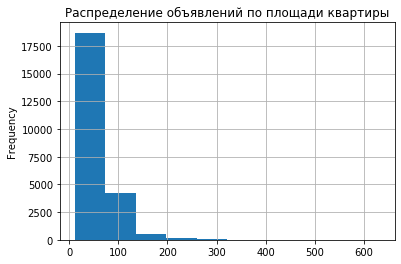

In [50]:
data['total_area'].plot(kind='hist', grid=True, title='Распределение объявлений по площади квартиры')

В таком виде гистограмма не слишком информативна - значения общей площади многокомнатных квартир делают большую часть гистограммы "пустой". 

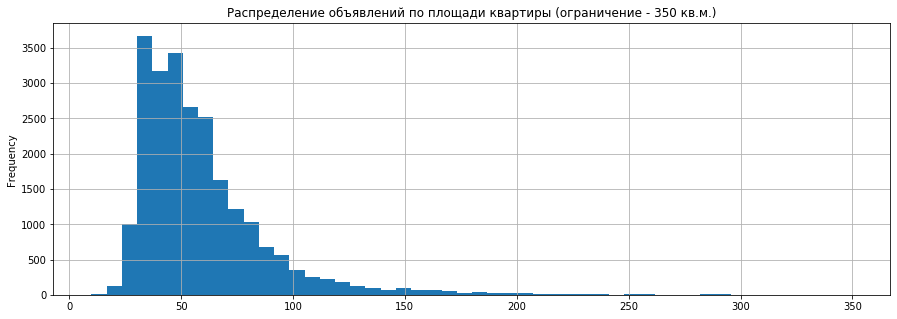

In [51]:
data['total_area'].plot(kind='hist', bins=50, range=(10, 350), figsize=(15, 5), \
grid=True, title='Распределение объявлений по площади квартиры (ограничение - 350 кв.м.)')

При увеличении числа корзин, ограничении диапазона площадей и увеличении размера графика мы видим, что большая часть объявлений о продаже квартир с общей площадью в диапазоне до 50 квадратных метров (медиана). Пики для квартир с площадями в районе 35, 42 и 49 квадратных метров. Вероятно, речь идет о квартирах с 1 и 2 комнатами, что довольно логично - так как такие предложения наиболее массовые. 

Первый резкий провал в районе 63 и 70 квадратных метров. Далее снижение идет довольно большими ступенями до уровня 100 метров, где шаг уменьшается и диаграмма становится более пологой. 

<p style="font-size:20px">4.2 Анализ цен</p>  

Проанализируем цены на недвижимость как в виде абсолютных значений, так и виде цены квадратного метра, которую мы рассчитали чуть выше. Для удобства мы добавим дополнительный вычисляемый столбец, цена в котором будет зафиксирована в миллионах. 

In [52]:
data['last_price_mlns'] = round(data['last_price'] / 1000000, 2)
#после точки оставим два знака для удобства ориентирования в объектах недвижимости бюджетного сегмента

In [53]:
data['last_price_mlns'].describe()

count    23584.000000
mean         6.430728
std         10.215493
min          0.010000
25%          3.400000
50%          4.615000
75%          6.750000
max        763.000000
Name: last_price_mlns, dtype: float64

Мы видим, что квартили выглядт вполне привычно: нижний ценовой сегмент находится в районе отметки в 3 миллиона - это, вероятно, распространенный вариант малогабаритной однокомнатной квартиры; далее отметка 4.5-5 миллионов - 2 комнаты и порядка 7 миллонов для трехкомнатных квартир - эти данные понятны на интуитивном уровне. 

Однако внимание в очередной раз привлекают внимание крайние значения выборки. Кроме того, довольно высоко среднеквадратичное отклонение. 

In [54]:
#посмотрим на количество квартир дешевле миллиона
print('Количество квартир дешевле 1 миллиона рублей: ', len(data.loc[data['last_price_mlns'] <= 1]))
data.loc[data['last_price_mlns'] <= 1].pivot_table(index='rooms', values=['total_area', 'price_per_sqm', 'last_price_mlns'])

Количество квартир дешевле 1 миллиона рублей:  244


,last_price_mlns,price_per_sqm,total_area
rooms,,,
1,0.768018,24354.711712,32.360360
2,0.776364,17677.525253,45.636364
3,0.884545,14898.121212,60.060606
4,1.000000,16112.000000,62.000000


Из сводной таблицы, где в качестве индексов выступает количество комнат в квартире, мы видим, что  диапазон комнат варьируется от отметки в 1 комнату, до 4. Мы можем предположить, что не все из этих значений являются аномалиями в чистом виде, но в целом - такие значения можно удалить из таблицы для повышения точности результатов итогового исследования;

Необходимо проверить гипотезу - крайне низкая цена обусловлена локацией. Для проверки гипотезы добавим в датасет столбец, в котором каждый объект будет отнесен к одной из трех групп: непосредственно Санкт-Петербург, областные города и "сельская местность" (населенные пункты, не являющиеся городами). 

In [55]:
def location_group(row):
    if row['locality_name'] == 'Санкт-Петербург':
        row['urban_group'] = 'Санкт-Петербург'
    elif len(row['locality_name'].split()) == 1:
        row['urban_group'] = 'Областной город'
    elif 'д.' or 'п.' or 'пгт' or 'снт' in row['locality_name'].split():
        row['urban_group'] = 'Сельская местность'
        
    return row
        
data = data.apply(location_group, axis=1)

In [56]:
#Теперь построим сводную таблицу по новому столбцу
data.loc[(data['last_price_mlns'] <= 1) & (data['rooms'] > 0)].\
pivot_table(index='urban_group', values=['total_area', 'price_per_sqm', 'last_price_mlns'])
#Явно выделяется квартира в СПб

,last_price_mlns,price_per_sqm,total_area
urban_group,,,
Областной город,0.786556,20100.814570,41.668874
Санкт-Петербург,0.010000,111.000000,109.000000
Сельская местность,0.799130,20933.304348,40.793478


In [57]:
data.drop(data.loc[(data['last_price_mlns'] <= 0.2) & (data['rooms'] == 2)].index, inplace=True) 
#удаляем "некорректную" квартиру из датасета
data = data.reset_index(drop=True) #сбрасываем индексы

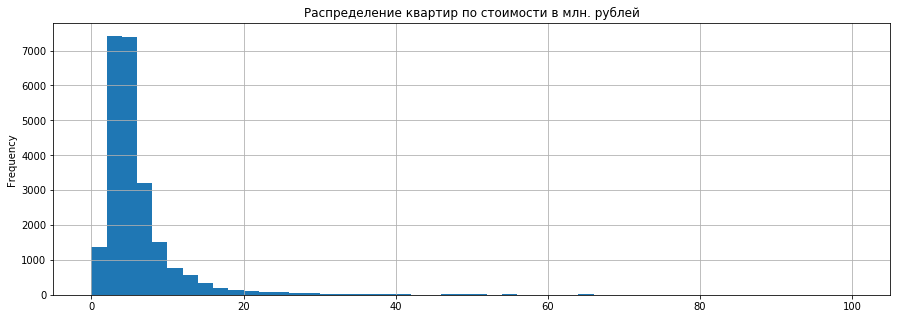

In [58]:
data['last_price_mlns'].plot(kind='hist', grid=True, bins=50, figsize=( 15, 5), range=(0, 100), title='Распределение квартир по стоимости в млн. рублей')
#даже с 50 корзинами гистограмму сложно назвать наглядной - влияют очень дорогие объекты недвижимости
#при ограничении диапазона рассматриваемых значений потолков 100 миллионов, мы получаем более понятную картину

Распределение унимодальное - при снижении количества корзин пики на 4 и 6 миллионах сольются. Это, вероятно, наиболее распространенные варианты жилья: либо 1-2 комнаты в городе, либо чуть большая площадь, но в пригороде. 

<p style="font-size:20px">4.3 Анализ количества комнат</p>  

In [59]:
data['rooms'].describe()

count    23583.000000
mean         2.068142
std          1.019517
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

Высказанные выше предположения о количестве комнат в наиболее распространнеых вариантах жилья находят подтверждение при оценки данных столбца:

1) Среднее и медианное значения практически одинаковы - 2 комнаты;

2) Отклонение - 1 комната

Анализ аномальных значение, заполнение пропусков и корректировка количества комнат уже были произведены.

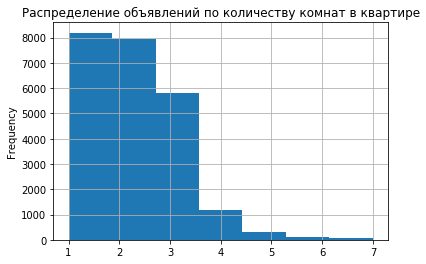

In [60]:
data['rooms'].plot(kind='hist', grid=True, bins=7, title='Распределение объявлений по количеству комнат в квартире') 
#ограничим количество корзин в гистограмме количеством возможных вариантов количества комнат в квартире - 7

Мы видим, что большая часть объявлений - это "народные" варианты в 1-2 комнаты (примерно 16 тысяч записей с незначительным преимуществом однокомнатных вариантов). Трехкомнатные квартиры также достаточно популярны, но количество таких объявление составляет примерно 75% от количества двухкомнатных (или однокомнатных) вариантов. С 4 комнат виден значительный "провал" - такой формат жилья уже доступен меньшему количеству покупателей. В относительных значения картина сопоставима и для пар 5-4 комнат, 6-5 комнат. 

<p style="font-size:20px">4.4 Анализ высоты потолков</p>  

Ранее в рамках анализа также была произведена нормализация данных в столбце с высотами потолков, поэтому мы можем просто оценить полученный результат и понять, какие варианты в наибольшей степени популярны.

In [61]:
data['ceiling_height'].describe()

count    23583.000000
mean         2.703991
std          0.219063
min          2.000000
25%          2.550000
50%          2.650000
75%          2.750000
max          4.000000
Name: ceiling_height, dtype: float64

Как видим, метод describe действительно возвращает нам вполне реалистиные значения. Среднее и медианные значения находятся на одном уровне (2.6-2.7 метра). Не обладая экспертизой в области возможных планировок квартир и высот потолков, я бы сказал, что средняя высота довольно большая. Вероятно, на это влияет год постройки дома, но мы не располагаем соответствующими данными для проверки гипотезы. 

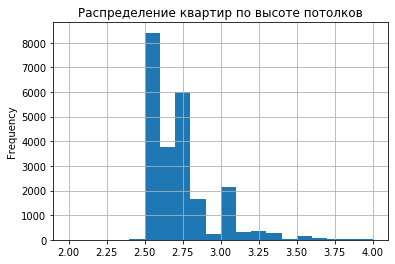

In [62]:
data['ceiling_height'].plot(kind='hist', grid=True, bins=20, title='Распределение квартир по высоте потолков')

Пиковое значение находится у отметки 2.5 метра, что похоже на правду, так как в бюджетном жилье потолок ниже. Далее мы наблюдаем некоторый провал при переходе к значению в 2.75 - вероятно, это как-то связано с особенностями типовых серий домов. 

<p style="font-size:20px">4.5 Анализ времени продажи квартир</p>  

Следует отметить, что пустые значения во времени продажи ранее были заполнены нулевыми значениями, поэтому при анализе времени продажи следует ориентироваться только на ту часть выборк, данные по которой у нас имеются. 

In [63]:
data['days_exposition'].describe()

count    23583.000000
mean       156.271764
std        213.007611
min          0.000000
25%         22.000000
50%         74.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [64]:
data['days_exposition'].loc[data['days_exposition'] != 0].describe()

count    20424.000000
mean       180.442470
std        219.154556
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Мы видим, что отказ от нулевых значений значительно сдвигает все метрики "вправо", что повышает точность результата анализа. 

В общем, 1 квартиль лежит на уровне 45 дней, но на уровне субъективной оценки - это довольно большой срок для недорогих "народных" вариантов жилья, поэтому на средние и медианные значения имеет смысль посмотреть через призму количества комнат в квартире. 

Необычно долгим же значение можно назвать все, что более 1 года (хотя 3 квартиль лежит на отметке в 231 день). Субъективно, записи с временем продажи более 1 года вызывают вопросы относительно своей достоверности. 

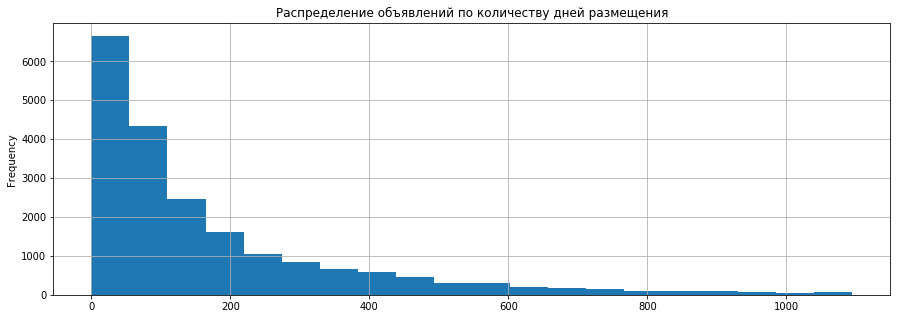

In [65]:
data['days_exposition'].loc[data['days_exposition'] != 0].plot(kind='hist', grid=True, bins=20, figsize=(15, 5), range=(0, 1095), title='Распределение объявлений по количеству дней размещения')
#ограничим диапазон значений для гистограммы и видим на нем похожую картину

In [66]:
data.loc[(data['days_exposition'] > 55) & (data['days_exposition'] < 65), 'days_exposition'].value_counts()
#data.loc[data['days_exposition'] == 45].describe()

60    537
61    108
59    106
63     99
64     88
56     86
62     74
57     74
58     72
Name: days_exposition, dtype: int64

In [67]:
data.pivot_table(index=['urban_group', 'rooms'], values=['days_exposition', 'last_price_mlns'], aggfunc=['mean', 'median'])

mean                          median  \
                         days_exposition last_price_mlns days_exposition   
urban_group        rooms                                                   
Областной город    1          144.798125        2.729856            62.0   
                   2          155.329054        3.539750            73.0   
                   3          157.418410        4.616862            69.0   
                   4          197.984848        6.650530            94.5   
                   5          109.263158        7.555263            57.0   
                   6           37.000000       18.533333            15.0   
                   7            9.000000       42.000000             9.0   
Санкт-Петербург    1          141.304990        4.445234            64.0   
                   2          149.227833        6.742592            71.0   
                   3          171.662119        9.651381            86.0   
                   4          206.288820       14.877433           104.0   
                   5          242.764085       24.037923           112.5   
                   6          201.416667       32.393333            90.0   
                   7          124.727273       51.642364            46.0   
Сельская местность 1          145.588629        2.855178            74.0   
                   2          150.649926        3.419136            74.0   
                   3          169.165075        4.435089            80.0   
                   4          175.354430        5.790000            90.0   
                   5          162.875000        6.735625            55.0   
                   6          241.000000       14.266667           162.0   
                   7           35.000000        7.900000            35.0   

                                          
                         last_price_mlns  
urban_group        rooms                  
Областной город    1               2.650  
                   2               3.235  
                   3               4.150  
                   4               4.625  
                   5               5.900  
                   6              14.500  
                   7              42.000  
Санкт-Петербург    1               4.070  
                   2               5.600  
                   3               7.190  
                   4              10.050  
                   5              14.400  
                   6              19.000  
                   7              24.900  
Сельская местность 1               2.900  
                   2               3.400  
                   3               4.400  
                   4               5.150  
                   5               5.995  
                   6              14.000  
                   7               7.900

<span style="font-family:Arial Black">Из полученной сводной таблицы можем сделать следующие выводы: </span>

1) Время продажи до 45 дней действительно можно считать хорошим. Условно, можно говорить о месяце как действительно "хорошем" времени продажи. Наша гипотеза не подтвердилась;

2) Мы видим, что "экономичные" варианты (1 и 2 комнаты) продаются максимально быстро в Санкт-Петербурге. Начиная с 3 и более комнат в квартире ситуация меняется - среднее время продажи для Санкт-Петербурга растет, а для области сокращается - вероятно; 

3) Обратная пропорциональная зависимость, вероятней всего, обусловлена средней стоимостью объекта недвижимости в Санкт-Петербурге и области (например, медианная стоимость двухкомнатной квартиры в СПб находится на уровне 4-5 комнатной квартиры в области). 

Все эти выводы, при необходимости, можно детализировать и уточнить через более глубокую сегментацию данных. 

<p style="font-size:20px">4.6 Анализ редких и выбивающихся значений</p> 

Еще раз взглянем на наши данные по наиболее важным параметрам для анализа и ответа на поставленные перед исследованием вопросы:

In [68]:
data[['total_area', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height']].describe()

,total_area,living_area,kitchen_area,rooms,ceiling_height
count,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000
mean,59.598864,34.254251,10.129246,2.068142,2.703991
std,33.382280,21.335756,5.707230,1.019517,0.219063
min,12.000000,2.000000,0.000000,1.000000,2.000000
25%,40.000000,19.000000,7.000000,1.000000,2.550000
50%,52.000000,30.000000,9.000000,2.000000,2.650000
75%,69.000000,42.000000,11.000000,3.000000,2.750000
max,631.000000,414.000000,107.000000,7.000000,4.000000


In [69]:
#Еще раз проделаем ту же саму процедуру но для значений до 1 квартиля
data.loc[data['living_area'] < 18, 'living_area'].describe()

count    4177.000000
mean       15.631554
std         1.650203
min         2.000000
25%        15.000000
50%        16.000000
75%        17.000000
max        17.000000
Name: living_area, dtype: float64

Явная проблема с минимальным значеним жилой площади. Ее надо исправить:

In [70]:
#наш датафрейм
room_liv_area_part_groups_comparison

,rooms,new_liv_area_part,old_liv_area_part
0,1,0.655937,0.490133
1,2,0.580324,0.579402
2,3,0.627911,0.625373
3,4,0.647172,0.646157
4,5,0.644394,0.642307
5,6,0.669708,0.669708
6,7,0.656364,0.656364
7,8,0.667001,0.667001
8,9,0.612299,0.612299
9,10,0.645065,0.645065


In [71]:
import numpy as np

def areas_checker(row):
    a = row['living_area'] / row['total_area']
    b = room_liv_area_part_groups[row['rooms']] - np.std(data['living_area_part'])
    areas_sum = row['living_area'] + row['kitchen_area']
    if a < b:
        row['living_area'] = row['total_area'] * room_liv_area_part_groups[row['rooms']]
    if row['total_area'] <= areas_sum:
        row['kitchen_area'] = 0
    return row
        
data = data.apply(areas_checker, axis=1)

In [72]:
data[['total_area', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height']].describe()

,total_area,living_area,kitchen_area,rooms,ceiling_height
count,23583.000000,23583.000000,23583.000000,23583.000000,23583.000000
mean,59.598864,37.348059,10.010643,2.068142,2.703991
std,33.382280,21.671869,5.711672,1.019517,0.219063
min,12.000000,8.000000,0.000000,1.000000,2.000000
25%,40.000000,25.581531,7.000000,1.000000,2.550000
50%,52.000000,31.000000,9.000000,2.000000,2.650000
75%,69.000000,43.000000,11.000000,3.000000,2.750000
max,631.000000,414.165396,107.000000,7.000000,4.000000


После нормализации значений в столбце `living_area` мы можем убедиться, что для любого измерения данных, представленных в резузультате работы метода  `.describe()`, данные корректны. 

<p style="font-size:20px">4.7 Анализ факторов, влияющих на стоимость продажи квартиры</p>  

В числе факторов, от которых потенциально может зависить стоимость объекта, по условию задания следующие:

- Цена 1 квадратного метра недвижимости
- Число комнат
- Этаж (первый или последний)
- Удаленность от центра

Таким образом, пул значений для проверки будет <span style="text-decoration:underline">ограничен следующими критериями: </span>

- Этаж первый или последний (промежуточные значения не учитываем)
- Удаленность от центра должна быть указана


In [73]:
len(data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['floor_quality'] != 'Другой')])

4360

Для надежности стоит проверить записей в датасете, которые имеют указанное значение расстояния до центра, но при этом не принадлежат к локации "Санкт-Петербург" для ответа на вопрос: "Не указано ли расстояние у таких записей до центра другого города". 

In [74]:
#Посмотрим, как распределились такие значения по населенным пунктам
data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['locality_name'] != 'Санкт-Петербург'), 'locality_name'].value_counts()

п. Шушары             436
Пушкин                367
Колпино               336
п. Парголово          327
Петергоф              201
Сестрорецк            183
Красное Село          175
Ломоносов             132
Кронштадт              93
п. Металлострой        66
п. Стрельна            44
Не указано             41
Павловск               38
Зеленогорск            24
п. Понтонный           20
п. Сапёрный             6
п. Молодёжное           5
п. Песочный             4
п. Репино               4
п. Лисий Нос            3
п. Усть-Ижора           2
п. Мурино               2
п. Александровская      2
п. Петро-Славянка       1
п. Белоостров           1
п. Левашово             1
п. Щеглово              1
Name: locality_name, dtype: int64

Так как я не обладаю экспертизой в областных городах-сателлитах Санкт-Петербурга, посмотрим на среднее расстояние до центра города по этим населенным пунктам:

In [75]:
data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['locality_name'] != 'Санкт-Петербург')]\
.pivot_table(index='locality_name', values='cityCenters_nearest')

,cityCenters_nearest
locality_name,
Зеленогорск,54617.583333
Колпино,32107.764881
Красное Село,30031.474286
Кронштадт,49176.956989
Ломоносов,50739.969697
Не указано,11278.902439
Павловск,33206.921053
Петергоф,35468.925373
Пушкин,28736.340599


Мы видим, что во всех случаях расстояния достаточно большие для того, чтобы мы предположили, что у всех строк значения указаны до центра Санкт-Петербурга. 

Построим матрицу корреляции между интересующими нас параметрами каждого объекта недвижимости:

In [76]:
data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['floor_quality'] != 'Другой')]\
[['last_price', 'price_per_sqm', 'total_area', 'rooms', 'floor', 'cityCenters_nearest']].corr()

,last_price,price_per_sqm,total_area,rooms,floor,cityCenters_nearest
last_price,1.000000,0.819780,0.567750,0.297625,0.051864,-0.145012
price_per_sqm,0.819780,1.000000,0.311156,0.063825,0.104655,-0.270607
total_area,0.567750,0.311156,1.000000,0.716924,0.040057,-0.180914
rooms,0.297625,0.063825,0.716924,1.000000,-0.066332,-0.176306
floor,0.051864,0.104655,0.040057,-0.066332,1.000000,-0.045310
cityCenters_nearest,-0.145012,-0.270607,-0.180914,-0.176306,-0.045310,1.000000


1) Видна довольна очевидная сильная корреляция между общей стоимостью объекта недвижимости и ценой 1 квадратного метра;

2) Присутствует слабая корреляция между количеством комнат и стоимостью объекта недвижимости - это вполне объяснимый факт, так как количество комнат не позволяет в полной мере охарактеризовать качество объекта в целом (например, комнаты могут быть многочисленными, но малогабаритными)

3) Наиболее интересная зависимость между расстоянием до центра города и стоимостью одного квадратного метра недвижимости - она слабая и отрицательная (то есть, уменьшение одного параметра влияет на рост другого), но довольно существенно выделяется на фоне остальных метрик, поэтому имеет смысл принимать ее во внимание при оценке недвижимости;

4) Очень слабая отрицательная корреляция между ценой объекта в общем и расстоянием от этого объекта до центра города, а также между расстоянием и количеством комнат. 

In [77]:
print('Коэффициент корреляции между ценой и днем недели:', data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['floor_quality'] != 'Другой'), 'last_price']\
.corr(pd.to_datetime(data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['floor_quality'] != 'Другой'), \
'first_day_exposition']).dt.dayofweek))

print('Коэффициент корреляции между ценой и месяцем:', data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['floor_quality'] != 'Другой'), 'last_price']\
.corr(pd.to_datetime(data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['floor_quality'] != 'Другой'), \
'first_day_exposition']).dt.month))

print('Коэффициент корреляции между ценой и годом:', data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['floor_quality'] != 'Другой'), 'last_price']\
.corr(pd.to_datetime(data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['floor_quality'] != 'Другой'), \
'first_day_exposition']).dt.year))

Коэффициент корреляции между ценой и днем недели: 0.02657767988832828
Коэффициент корреляции между ценой и месяцем: -0.0033137185745025217
Коэффициент корреляции между ценой и годом: -0.01440665125621007


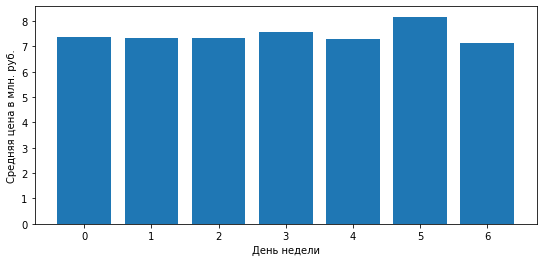

In [78]:
import matplotlib.pyplot as plt
analysis = data.loc[(data['cityCenters_nearest'].isnull() == False)]\
.pivot_table(index='weekday_published', values='last_price_mlns').sort_values('weekday_published')
analysis = analysis.reset_index()

index = analysis['weekday_published']
values = analysis['last_price_mlns']

fig, ax = plt.subplots()
plt.bar(index, values)
fig.set_figwidth(9)
ax.set_xlabel('День недели')
ax.set_ylabel('Средняя цена в млн. руб.')
plt.show()

Мы видим, что средняя цена объекта недвижимости в субботу выделяется на фоне остальных. Вероятно в течение недели происхоидт сбор информации о более дорогих объектах недвижмости. Альтернативный вариант - риэлтор, ответственный за публикацию, может организовать просмотр и, как следствие, публикацию объявления только в выходные.

In [79]:
analysis = data.loc[(data['cityCenters_nearest'].isnull() == False),\
['first_day_exposition', 'last_price_mlns']]
analysis['month_published'] = pd.to_datetime(data['first_day_exposition']).dt.month
analysis['year_published'] = pd.to_datetime(data['first_day_exposition']).dt.year
#если в первом случае мы воспользовались днем недели, который добавили в исходный датафрейм изначально, то для
#построения графиков по месяцу и году используем отдельный небольшой датафрейм с нужными данными

analysis.sample(10)

,first_day_exposition,last_price_mlns,month_published,year_published
19041,2017-06-20,3.20,6,2017
6730,2015-11-01,5.60,11,2015
18952,2016-01-25,4.65,1,2016
17792,2016-06-07,12.48,6,2016
2286,2018-03-01,4.00,3,2018
17410,2019-01-29,11.05,1,2019
11794,2017-05-29,7.70,5,2017
15595,2018-09-01,6.00,9,2018
20912,2016-03-19,3.70,3,2016
11360,2018-02-01,4.20,2,2018


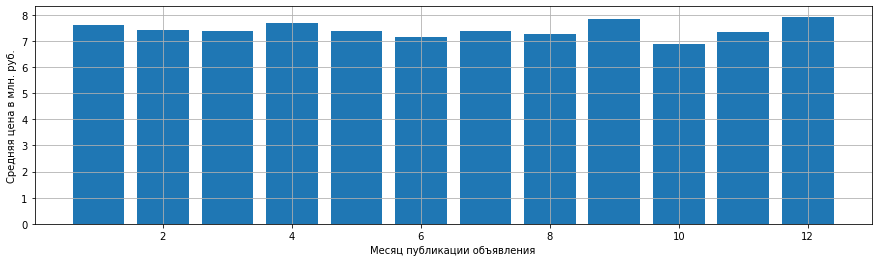

In [80]:
month_pivot = analysis.pivot_table(index='month_published', values='last_price_mlns').sort_values('month_published')
month_pivot = month_pivot.reset_index()

index = month_pivot['month_published']
values = month_pivot['last_price_mlns']

fig, ax = plt.subplots()
plt.bar(index, values)
ax.set_xlabel('Месяц публикации объявления')
ax.set_ylabel('Средняя цена в млн. руб.')
fig.set_figwidth(15)
ax.grid()
plt.show()

Мы видим, что в течении года средняя цена квартиры тяготеет к отметке в 7 миллонов. Исколючение сентябрь - в этом месяца средняя стоимость квартиры немного выше 9 миллионов. 

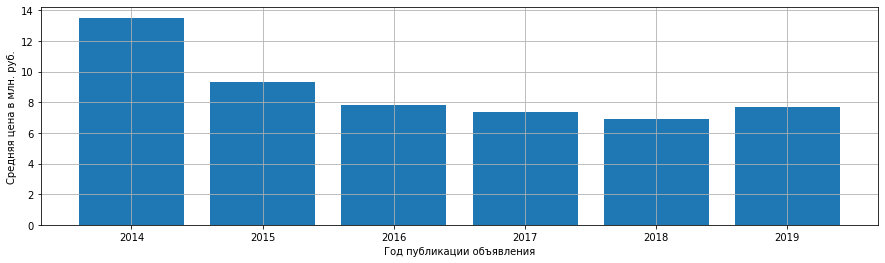

In [81]:
yr_pivot = analysis.pivot_table(index='year_published', values='last_price_mlns').sort_values('year_published')
yr_pivot = yr_pivot.reset_index()

index = yr_pivot['year_published']
values = yr_pivot['last_price_mlns']

fig, ax = plt.subplots()
plt.bar(index, values)
ax.set_xlabel('Год публикации объявления')
ax.set_ylabel('Средняя цена в млн. руб.')
fig.set_figwidth(15)
ax.grid()
plt.show()

Наиболее выраженный перепад мы наблюдаем при анализе средней цены объекта недвижимости за год - мы видим двухкратное снижение в период между 2014 и 2015 годами. В 2016-2017 годах продолжается снижение, но минимальное. Можно предположить, что резкий спад обусловлен последствиями начавшегося экономического кризиса и резкого снижения доходов населения. Влоть до 2018 года средняя цена объекта недвижимости снижалась и только в 2019 году начала расти. 

Гипотеза: снижение стоимости на "люксовую" недвижимость вкупе с ростом спроса на бюджетные объекты - это два ключевых драйвера рыночной тенденции, представленной на графике. 

In [82]:
yr_pivot_2014 = analysis.loc[analysis['year_published'] == 2014].pivot_table(index='month_published',\
values='last_price_mlns')
display(yr_pivot_2014)

,last_price_mlns
month_published,
11,13.538000
12,13.514362


Мы видим, что располагаем информацией об опубликованных в 2014 году объявлениях только за два месяца: ноябрь и декабрь. Это менее 20% данных по году, поэтому выводы на базе этой информации будут еще менее точными. Однако, мы понимаем, что кризис в 2014 году начался ранее и такие цены на недвижимость в конце года - это попытка "заморозить" деньги, обсуловленная резким падением курса валюты. 

In [83]:
locality_top10 = pd.DataFrame.from_dict(data['locality_name'].value_counts().head(10).to_dict(), \
orient='index', columns=['rows'])
#отбираем 10 населенных пунктов с наибольшим количеством объявлений и записываем их в словарь, который преобразуем в
#датафрейм
locality_top10.reset_index(inplace=True)
locality_top10.columns=['locality_name', 'rows']

locality_top10.head(10)

,locality_name,rows
0,Санкт-Петербург,15625
1,п. Мурино,554
2,п. Шушары,440
3,Всеволожск,397
4,Пушкин,368
5,Колпино,337
6,п. Парголово,327
7,Гатчина,306
8,д. Кудрово,299
9,Выборг,236


In [84]:
data_grouped = data.groupby('locality_name')
data_grouped = data_grouped['last_price', 'price_per_sqm'].mean().astype(int)
#группируем исходный датафрейм по локации и считаем среднее по цене и цене за квадратный метр - на выходе получаем
#новый датафрейм с нужными параметрами и полным списком локаций из выборки

In [85]:
locality_top10 = locality_top10.join(data_grouped, on='locality_name')
#соеднияем два полученных датафрейма и получаем топ10 населенных пунктов с количеством объявлений, средней ценой и 
#средней ценой за квадратный метр
display(locality_top10)

,locality_name,rows,last_price,price_per_sqm
0,Санкт-Петербург,15625,7903044,115061
1,п. Мурино,554,3653272,86288
2,п. Шушары,440,4108081,79068
3,Всеволожск,397,3790803,68935
4,Пушкин,368,6458625,103542
5,Колпино,337,3866288,75644
6,п. Парголово,327,4488074,90675
7,Гатчина,306,3487971,69056
8,д. Кудрово,299,4234157,93001
9,Выборг,236,3236792,58248


<span style="font-family:Arial Black">Выводы по задаче:</span>

1) Санкт-Петербург лидер по всем параметрам: больше всего объявлений, самая высокая средняя стоимость объекта недвижимости и самая высокая цена 1 квадратного метра;

2) На втором месте по стоимости с незначительным отрывом - Пушкин.  Эти два населенных пункта можно назвать самыми дорогими в нашем датасете. 

3) Самые "бюджетные" варианты располагаются во Всеволожске и Выборге. 

<p style="font-size:20px">4.8 Анализ расстояния до центра города</p> 

В соответствии с условиями поставленной задачи, нам необходимо добавить в таблицу новый столбец с расстоянием в километрах и округлить его до целых значений, однако ранее мы уже пересчитали значения исходного столбца в километры и округлили до 1 знака после точки из соображений упрощения восприятия значений в таблице, так как десятки и единицы метров в расстоянии до таких объектов вряд ли будут иметь принципиальное значение. Поэтому мы добавим новый столбец без пересчета, но с округлением до целого значения:

In [86]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000, 0)
data.loc[data['locality_name'] == 'Санкт-Петербург']\
.pivot_table(index='cityCenters_nearest_km', values='last_price_mlns')
#по значениям исходного датасета, где в качестве локации указан Санкт-Петербург, мы строим сводную таблицу
#при этом, используем в качестве значений столбец с ценой объекта в миллионах - в противном случае
#данные о средней цене будут представлены в научной нотации, что затрудняет восприятие

,last_price_mlns
cityCenters_nearest_km,
0.0,33.044800
1.0,20.706489
2.0,17.644452
3.0,10.922558
4.0,12.884711
5.0,14.164934
6.0,14.351351
7.0,14.474844
8.0,9.152640


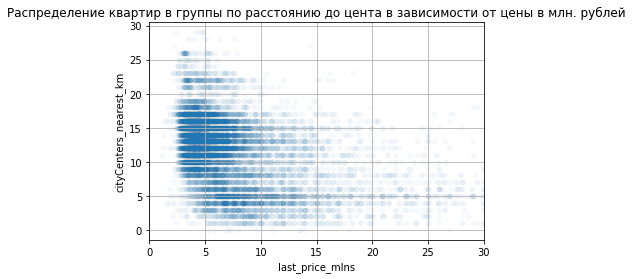

In [87]:
data.loc[data['locality_name'] == 'Санкт-Петербург'].plot(alpha=0.03, \
grid=True, x='last_price_mlns', y='cityCenters_nearest_km', style='x', xlim=(0, 30), kind='scatter', \
title='Распределение квартир в группы по расстоянию до цента в зависимости от цены в млн. рублей')

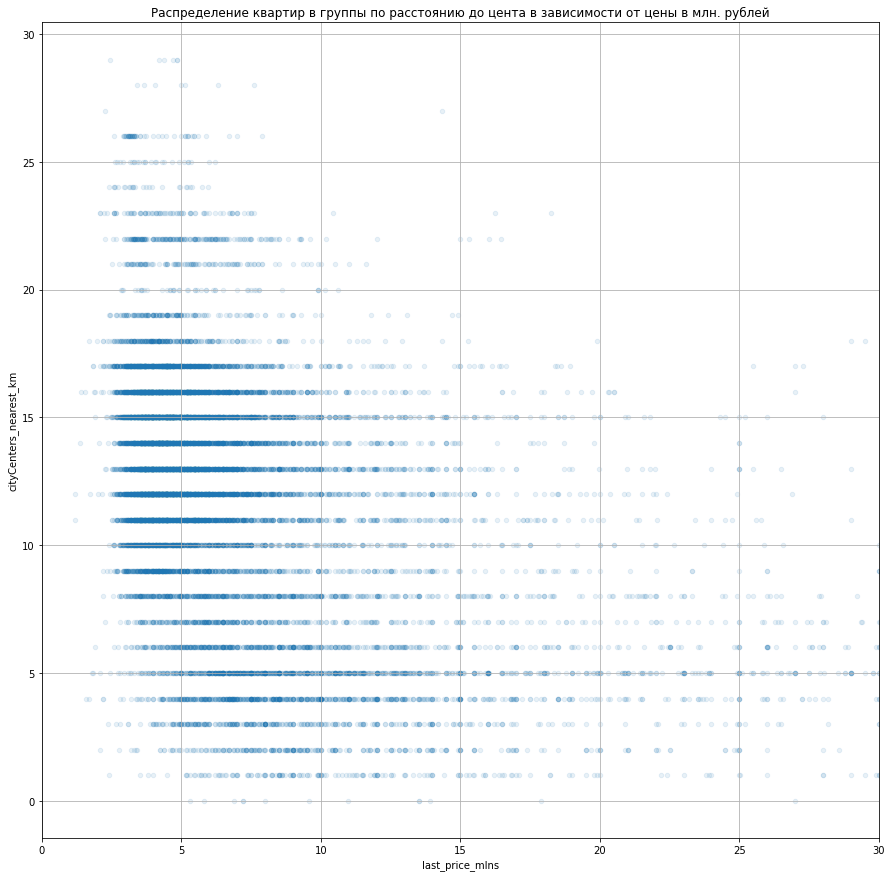

In [88]:
data.loc[data['locality_name'] == 'Санкт-Петербург'].plot(alpha=0.1, \
grid=True, x='last_price_mlns', y='cityCenters_nearest_km', style='x', figsize=(15, 15), xlim=(0, 30), kind='scatter',\
title='Распределение квартир в группы по расстоянию до цента в зависимости от цены в млн. рублей')

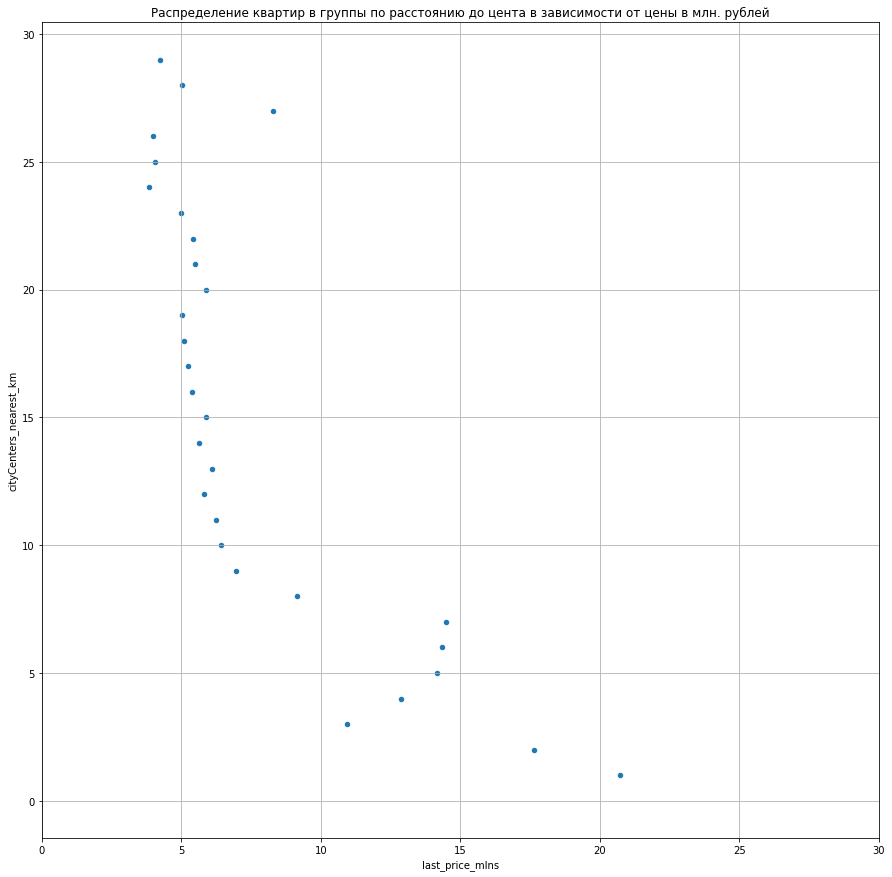

In [89]:
pivot_for_scatter = data.loc[data['locality_name'] == 'Санкт-Петербург'].pivot_table(index='cityCenters_nearest_km', values='last_price_mlns')
pivot_for_scatter = pivot_for_scatter.reset_index()
pivot_for_scatter.plot(grid=True, x='last_price_mlns', y='cityCenters_nearest_km', style='x', figsize=(15, 15), xlim=(0, 30), kind='scatter',\
title='Распределение квартир в группы по расстоянию до цента в зависимости от цены в млн. рублей')

<span style="font-family:Arial Black">Выводы по заданию:</span>

Судя по малому графику, "спальные районы" (то есть такие, в которых целенаправленно большую часть площади застраивают домами высокой плотности) начинаются примерно с 8 километра от центра. 

Однако на двух графиках видно, что "первый круг" центра - это отметка между 3 и 4 километром от центра (наиболее популярный сегмент жилья тут от 5 до 12-13 миллионов).

"Второй круг" - это отметка 8-9 километров - здесь линии становятся максимально плотными (много вариантов жилья). Кроме того, здесь существенно смещается к оси Y средняя стоимость объектов недвижимости - диапазон от 2.5 до 7.5 миллионов. 

<p style="font-size:20px">4.9 Анализ "квартир в центре"</p> 

Построим сводную таблицу для анализа целевых параметров по сегменту "квартир в центре" в Санкт-Петербурге:

In [90]:
data.loc[(data['cityCenters_nearest_km'] <= 8) & (data['locality_name'] == 'Санкт-Петербург')].\
pivot_table(index='cityCenters_nearest_km', values=['total_area', 'last_price_mlns', 'rooms', 'ceiling_height'], \
aggfunc=['mean', 'median', 'count'])

mean                                        \
                       ceiling_height last_price_mlns     rooms  total_area   
cityCenters_nearest_km                                                        
0.0                          3.166000       33.044800  3.160000  119.600000   
1.0                          3.059415       20.706489  3.207447  103.372340   
2.0                          3.091462       17.644452  3.073090  100.767442   
3.0                          3.044273       10.922558  2.970930   89.252907   
4.0                          2.981274       12.884711  2.911111   89.979259   
5.0                          2.959812       14.164934  2.774834   93.316777   
6.0                          2.863641       14.351351  2.551895   86.728171   
7.0                          2.822206       14.474844  2.424460   79.599520   
8.0                          2.792927        9.152640  2.279188   71.106599   

                               median                                   \
                       ceiling_height last_price_mlns rooms total_area   
cityCenters_nearest_km                                                   
0.0                              3.07          27.000     3      100.0   
1.0                              3.00          11.275     3       86.0   
2.0                              3.00           9.900     3       86.0   
3.0                              3.00           8.410     3       79.0   
4.0                              3.00           9.150     3       80.0   
5.0                              3.00           9.400     3       79.5   
6.0                              2.80           8.780     2       71.0   
7.0                              2.75           7.800     2       69.0   
8.0                              2.70           7.440     2       62.0   

                                count                                   
                       ceiling_height last_price_mlns rooms total_area  
cityCenters_nearest_km                                                  
0.0                                25              25    25         25  
1.0                               188             188   188        188  
2.0                               301             301   301        301  
3.0                               344             344   344        344  
4.0                               675             675   675        675  
5.0                               906             906   906        906  
6.0                               607             607   607        607  
7.0                               417             417   417        417  
8.0                               591             591   591        591

<span style="font-family:Arial Black">Выводы:</span>

1) Если в сегменте бюджетных квартир самая "популярная" высота потолка находится у отметки в 2.5 метра, а 2.65 - это медиана всей выборки, то в центральной части эта цифра стремится к 3 метрам с небольшим снижением по мере удаления от центра: вероятно, высокие потолки - это историческое наследие. Снижение высоты потолков объясняется типовой советской застройкой (предполагаю, активно она начинается с 5-6 километра от центра)

2) В отличие от центрообразуещей отметки в 5 миллионов за квартиру в бюджетном сегменте и среднего значение всей выборки в 6.4 миллиона, стоимость жилья в центре по медиане выше до двух раз, а среднее значение в центре и вовсе выше в 2-3 раза, что говорит нам о существенном разрыве в стоимости двух сегментов и высоком престиже проживания в центре города 

3) Количество комнат у квартир в центре также больше, чем у бюджетных вариантов: ранее мы определили, что 2 комнаты - это одновременно и среднее и медианное значение для всей выборки. Такой формат наиболее популярен в бюджетном сегменте, хотя трехкомнатные квартиры также пользуются популярностью - вероятно, "для расширения площади" в силу житейских обстоятельств (например, с рождением детей). В центре же комнат обычно больше на 1 - и среднее и медианное значению тяготеют к отметке в 3 комнаты. Вероятно, это можно объяснить общей состоятельностью покупателей таких объектов недвижимости

4) Ранее было установлено, что для бюджетных вариантов можно выделить 3 наиболее популярных типоразмера квартир по площади (цифры ориентировочные): 35, 42 и 50 квадратных метров. Медиана для выборки - 52 квадратных метра. В случае квартир в центре мы можем выделить два важных момента: медианная и средняя площадь "квартир в центре" тем больше, чем ближе квартире к центру города - это объяснимо снижением приоритета "вопроса денег" над уровнем комфорта для покупателей таких объектов недвижимости; медианная площадь квартиры примерно на 30-60% больше, чем в сегменте бюджетного жилья. 

In [91]:
data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['floor_quality'] != 'Другой') &\
         (data['cityCenters_nearest_km'] <=8)]\
[['last_price', 'price_per_sqm', 'total_area', 'rooms', 'floor', 'cityCenters_nearest']].corr()
#посмотрим на корреляцию для центра СПб

,last_price,price_per_sqm,total_area,rooms,floor,cityCenters_nearest
last_price,1.000000,0.857486,0.592087,0.307349,0.161795,-0.057052
price_per_sqm,0.857486,1.000000,0.339688,0.088374,0.175048,-0.061043
total_area,0.592087,0.339688,1.000000,0.718735,0.230076,-0.113254
rooms,0.307349,0.088374,0.718735,1.000000,0.099589,-0.174884
floor,0.161795,0.175048,0.230076,0.099589,1.000000,0.154099
cityCenters_nearest,-0.057052,-0.061043,-0.113254,-0.174884,0.154099,1.000000


In [92]:
data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['floor_quality'] != 'Другой') &\
         (data['cityCenters_nearest_km'] > 8)]\
[['last_price', 'price_per_sqm', 'total_area', 'rooms', 'floor', 'cityCenters_nearest']].corr()
#и такая же матрица корреляции, но для квартир за пределами "центра"

,last_price,price_per_sqm,total_area,rooms,floor,cityCenters_nearest
last_price,1.000000,0.472280,0.841258,0.491855,0.115873,-0.059576
price_per_sqm,0.472280,1.000000,0.007329,-0.244443,0.242590,-0.213566
total_area,0.841258,0.007329,1.000000,0.684287,0.027941,0.037637
rooms,0.491855,-0.244443,0.684287,1.000000,-0.110057,-0.023067
floor,0.115873,0.242590,0.027941,-0.110057,1.000000,0.032547
cityCenters_nearest,-0.059576,-0.213566,0.037637,-0.023067,0.032547,1.000000


<span style="font-family:Arial Black">Есть несколько заметных отличий:</span>

1. Для центра СПб наблюдается сильная корреляция между стоимость 1 квадратного метра и общей стоимостью квартиры. Для квартир за пределами центра она падает ниже среднего. Это обусловлено меньшей площадью "центра" и более высокой концентрацией объектов недвижимости в нем - выше "конкуренция" за 1 кв. м.

2. Но наблюдается противоположная тенденция - зависимость между общей площадью и ценой становится значительно более выраженной - в бюджетном сегменте люди предпочитают получить больше метров за свои деньги. Учитывае ранее сформулированный вывод о средней площади и количестве комнат в бюджетном и люксовом сегментах, это вполне объяснимо: покупка двухкомнатной квартиры в 45-50 квадратов существенно улучшает жилищные условия, если ранее речь шла о варианте в 1 комнату площадью 30-35 квадратных метров;

3. От слабых значение к условно "слабо-средним" поднимается зависимость цены от количества комнат в бюджетном сегменте; 

In [93]:
analysis = data.loc[(data['cityCenters_nearest'].isnull() == False) & (data['cityCenters_nearest_km'] <= 8) ,['first_day_exposition', 'last_price_mlns']]
analysis['weekday_published'] = pd.to_datetime(data['first_day_exposition']).dt.dayofweek
analysis['month_published'] = pd.to_datetime(data['first_day_exposition']).dt.month
analysis['year_published'] = pd.to_datetime(data['first_day_exposition']).dt.year

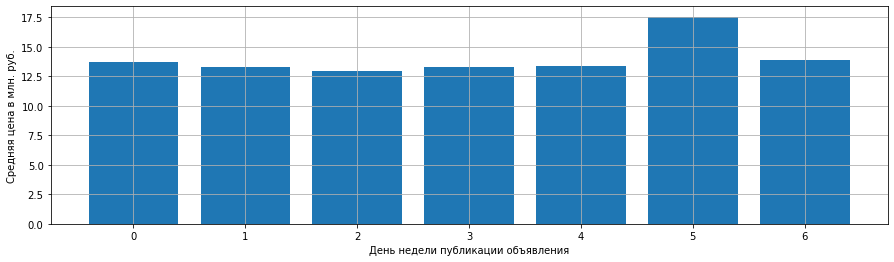

In [94]:
weekday_pivot = analysis.pivot_table(index='weekday_published', values='last_price_mlns')
weekday_pivot = weekday_pivot.reset_index()

index = weekday_pivot['weekday_published']
values = weekday_pivot['last_price_mlns']

fig, ax = plt.subplots()
plt.bar(index, values)
ax.set_xlabel('День недели публикации объявления')
ax.set_ylabel('Средняя цена в млн. руб.')
fig.set_figwidth(15)
ax.grid()
plt.show()

Мы видим, что применительно к сегменту квартир в центре города сохраняется тенденция к более высокой среденей цене квартиры в объявлении. 

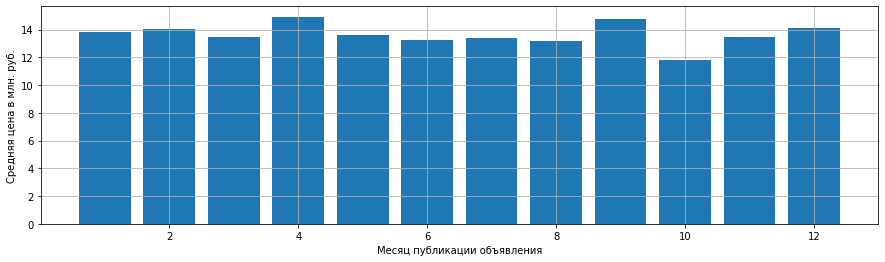

In [95]:
month_pivot = analysis.pivot_table(index='month_published', values='last_price_mlns')
month_pivot = month_pivot.reset_index()

index = month_pivot['month_published']
values = month_pivot['last_price_mlns']

fig, ax = plt.subplots()
plt.bar(index, values)
ax.set_xlabel('Месяц публикации объявления')
ax.set_ylabel('Средняя цена в млн. руб.')
fig.set_figwidth(15)
ax.grid()
plt.show()

В случае сегмента дорогих квартир в центре, средняя цена объекта по месяца более равномерно распределена в течение года. Единственный интересный момент это рост цены в сентябре и последующий спад в октябре. Возможно, это какой-то феномен сезонности. 

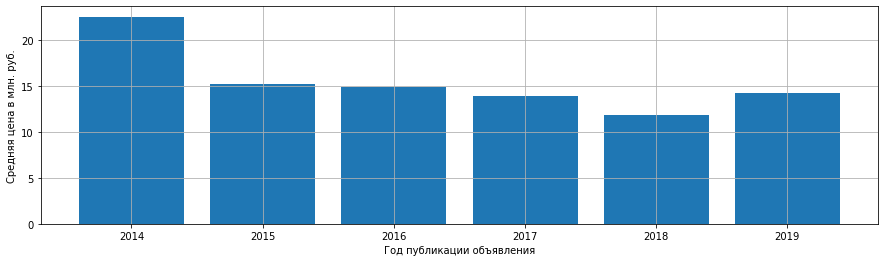

In [96]:
yr_pivot = analysis.pivot_table(index='year_published', values='last_price_mlns')
yr_pivot = yr_pivot.reset_index()

index = yr_pivot['year_published']
values = yr_pivot['last_price_mlns']

fig, ax = plt.subplots()
plt.bar(index, values)
ax.set_xlabel('Год публикации объявления')
ax.set_ylabel('Средняя цена в млн. руб.')
fig.set_figwidth(15)
ax.grid()
plt.show()

Тенденция к спаду в период 2014-2015 годов сохраняется для элитного жилья. Более того, учитывая влияние цен дорогих объектов недвижимости на общую величину среднего, можно сформулировать гипотезу: спад средней цены объекта недвижимости в 2014-2015 годах произошел в большей степени за счет снижения спроса на люксовые квартиры.

### Шаг 5. Общий вывод

<span style="font-family:Arial Black">Общие выводы по проекту:</span>

1. Установлено, что квартиры, в целом, можно разделить на два вида: **дорогие** в центре города и **бюджетные**, расположенные в других районах города или пригороде;

2. Условная средняя квартира бюджетного сегмента имеет ряд характерных признаков: площадь в диапазоне 30-50 квадратных метров; количество комнат 1-2, высота потолков около 2.5 метров;

3. Условная средняя квартира в центре города также имеет ряд характерных признаков: площадь 70-100 квадратных метров, не менее 3 комнат, высота потолков 2.7 метра и выше;

4. Самый "дешевый" этаж - 1 (медианная цена объекта недвижимости тут - 3.9 млн. рублей). Самый "дорогой" этаж - 30 (медианная цена объекта - 10.15 млн. рублей)

4. Наиболее важные факторы для квартир бюджетного сегмента: цена объекта, цена квадратного метра, общая площадь объекта. Люди готовы жертвовать расстоянием до центра города и инфраструктурных объектов для получения большей площади за свои деньги;

5. Наиболее важные факторы для "дорогих" квартир: площадь, количество комнат, высота потолков, удаленность от центра города и инфраструктурных объектов;

6. Для дорогих и дешевых квартир наблюдается интересная зависимость: на цену объекта в бюджетном сегменте в большей степени влияет общее количество квадратных метров, в то время как в дорогом сегменте усиливается влияение стоимости 1 квадратного метра;

7. Выявлено, что в сегмент "дорогих" квартир входят те, расстояние у которых до центра города равно или менее 8 километров. При этом, по расстоянию до центра города этот сегмент делится на две части 0-4 километра от центра города и 4-8 километров от центра города;

8. По аналогии, в бюджетном сегменте также можно выделить две группы: областные города (города сателлиты) и селькая местность (различные поселки, деревни и села). В среднем, в сельской местности ниже время размещения объявления для квартир с более чем 4 комнатами. При наличии данных о типе объекта недвижимости можно было бы проверить гипотезу, являются ли "многокомнатные" объекты недвижимости домами;

9. Если исключить из выборки Санкт-Петербург, то наиболее популярные населенные пункты: п. Мурино, п. Шушары, г. Всеволожск, г. Пушкин. При этом, Всеволожск среди приведенных отличается значительно меньшей средней стоимостью 1 квадратного метра жилья: порядка 70 тысяч против 80-100 в других населенных пунктах.
